In [2]:
# load data into df
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [79]:
orders = pd.read_csv('orders_data_competition.csv')
clients = pd.read_csv('clients_data_competition.csv')

### RFM analysis

In [86]:
# do rfm analysis
# recency, frequency, monetary
clients['Is Dormant'] = clients['Is Dormant'].replace(-1.0, 1)
clients['Is Dormant'] = clients['Is Dormant'].replace(0.0, 0)
# use astype to convert to int
clients['Is Dormant'] = clients['Is Dormant'].astype(int)
# clients.head()

# join orders and clients on Account ID
merged = pd.merge(orders, clients, on='Account ID', how='inner')

# filter out cancelled orders
merged = merged[merged['Is Canceled'] == 0]



In [89]:
# change column Is Dormant from -1 to 1 instead
# value counts of Is Dormant
merged['Is Dormant'].value_counts()

0    1568499
1      27050
Name: Is Dormant, dtype: int64

In [91]:
# assign churned to clients Is Dormant or Is Closed
clients['Churned'] =(clients['Is Dormant'] == 1) | (clients['Is Closed'] == 1)
# value counts
clients['Churned'].value_counts()
# show sum of Is Dormant accounts
# clients['Is Dormant'].sum()

False    11125
True      2398
Name: Churned, dtype: int64

In [92]:
# Converting Order Time and calculating Recency
merged['Order Time'] = pd.to_datetime(merged['Order Time'])
max_date = merged['Order Time'].max()
merged['Recency'] = (max_date - merged['Order Time']).dt.days

In [93]:
# Filling NaT values with the earliest date if found
if merged['Order Time'].isna().any():
    earliest_date = merged['Order Time'].min()
    merged['Order Time'].fillna(earliest_date, inplace=True)


In [117]:
# Calculating Net Income
merged['net_income'] = np.where(merged['Order Type'] == 'Sell', 
                                merged['Executed Quantity'] * merged['Price'], 
                                -merged['Executed Quantity'] * merged['Price'])

# 

count    1.595549e+06
mean     1.901379e+03
std      1.292814e+06
min     -2.115000e+08
25%     -6.566100e+03
50%      0.000000e+00
75%      5.430000e+03
max      1.249960e+09
Name: net_income, dtype: float64

In [119]:
# Converting Order Time and calculating Recency
merged['Order Time'] = pd.to_datetime(merged['Order Time'])
today = pd.to_datetime('2024-04-19')
merged['Recency'] = (today - merged['Order Time']).dt.days

# check if there is any nan
print(merged['Recency'].isna().sum())

# Calculating Frequency
frequency = merged.groupby('Account ID').size().reset_index(name='Frequency')

# Calculating Net Income
merged['net_income'] = np.where(merged['Order Type'] == 'Sell', 
                                merged['Executed Quantity'] * merged['Price'], 
                                -merged['Executed Quantity'] * merged['Price'])

# normalize
merged['net_income'] = (merged['net_income'] - merged['net_income'].mean()) / merged['net_income'].std()

# Calculating Monetary
monetary = merged.groupby('Account ID')['net_income'].sum().reset_index()
monetary.rename(columns={'net_income': 'Monetary'}, inplace=True)

# Merging Frequency and Monetary with the main dataframe
rfm_data = pd.merge(frequency, monetary, on='Account ID')

# # Ensure proper grouping and minimum calculation
# rfm_data['Recency'] = merged.groupby('Account ID')['Recency'].min()
# Create a dictionary to store minimum Recency for each Account ID
min_recency_dict = {}
for account_id in merged['Account ID'].unique():
    # Get the minimum Recency for the current Account ID from merged DataFrame
    min_recency = merged[merged['Account ID'] == account_id]['Recency'].min()
    min_recency_dict[account_id] = min_recency

# Create the Recency column in rfm_data using the minimum recency values from the dictionary
rfm_data['Recency'] = rfm_data['Account ID'].map(min_recency_dict)

# Check if any Account ID in rfm_data did not get a Recency value
print("Missing 'Recency' values count:", rfm_data['Recency'].isna().sum())



# Assigning RFM Scores
rfm_data['RecencyScore'] = pd.qcut(rfm_data['Recency'], 5, labels=[5, 4, 3, 2, 1], duplicates='drop')
rfm_data['FrequencyScore'] = pd.qcut(rfm_data['Frequency'], 5, labels=[1, 2, 3, 4, 5], duplicates='drop')
rfm_data['MonetaryScore'] = pd.qcut(rfm_data['Monetary'], 5, labels=[1, 2, 3, 4, 5], duplicates='drop')

# Combining RFM scores into a single string
rfm_data['RFM'] = rfm_data['RecencyScore'].astype(str) + rfm_data['FrequencyScore'].astype(str) + rfm_data['MonetaryScore'].astype(str)

# Summarizing RFM scores
rfm_summary = rfm_data.groupby('RFM').size().reset_index(name='Count').sort_values(by='Count', ascending=False)

# Identifying Top 10 Customers by Monetary Value
top_10_customers = rfm_data.sort_values(by='Monetary', ascending=False).head(10)


0
Missing 'Recency' values count: 0


In [120]:
top_10_customers

,Account ID,Frequency,Monetary,Recency,RecencyScore,FrequencyScore,MonetaryScore,RFM
7465,10636,2,1205.367431,814,1,1,5,115
1989,2817,49,351.387502,79,3,3,5,335
6327,9127,2,348.075071,767,1,1,5,115
3386,5032,26,283.823588,91,3,3,5,335
6462,9307,1567,271.597602,39,5,5,5,555
5355,7757,6,183.690909,711,1,2,5,125
6455,9300,759,180.009061,58,3,5,5,355
1806,2525,23,179.589666,51,4,3,5,435
3606,5312,15,159.013939,94,3,2,5,325
7258,10364,117,146.496217,45,4,4,5,445


In [122]:
# Calculate churn flag in the 'clients' DataFrame
clients['Churn'] = (clients['Is Dormant'] == 1) | (clients['Is Closed'] == 1)
# Print value counts of churn
print(clients['Churn'].value_counts())

# Merge the 'Churn' flag from clients into the 'merged' DataFrame before grouping
merged = pd.merge(merged, clients[['Account ID', 'Churn']], on='Account ID', how='left')

# Grouping by Account ID to get 'Churn' status for each account
churned = merged.groupby('Account ID')['Churn'].max().reset_index()

# Merge the churn data back into the rfm_data DataFrame
rfm_data = pd.merge(rfm_data, churned, on='Account ID', how='right')

# Fill any missing values in 'Churn' after merge and convert to integer
rfm_data['Churn'] = rfm_data['Churn'].fillna(False).astype(int)

# Display the first few rows to verify the merge and the data type
rfm_data.head()


False    11125
True      2398
Name: Churn, dtype: int64


,Account ID,Frequency,Monetary,Recency,RecencyScore,FrequencyScore,MonetaryScore,RFM,Churn
0,0,2,-0.014204,547,1,1,3,113,0
1,1,6,-0.005633,582,1,2,4,124,1
2,2,19,-0.133987,50,4,3,2,432,0
3,3,77,-0.078903,39,5,4,3,543,0
4,4,20,0.034293,52,4,3,5,435,0


In [126]:
def assign_segment(row):
    score_sum = sum([int(x) for x in str(row['RFM'])])
    if score_sum >= 13:
        return 'Platinum'
    elif 10 <= score_sum <= 12:
        return 'Gold'
    elif 7 <= score_sum <= 9:
        return 'Silver'
    else:
        return 'Bronze'

# Apply segmentation
rfm_data['Segment'] = rfm_data.apply(assign_segment, axis=1)
rfm_data.head()

,Account ID,Frequency,Monetary,Recency,RecencyScore,FrequencyScore,MonetaryScore,RFM,Churn,Segment
0,0,2,-0.014204,547,1,1,3,113,0,Bronze
1,1,6,-0.005633,582,1,2,4,124,1,Silver
2,2,19,-0.133987,50,4,3,2,432,0,Silver
3,3,77,-0.078903,39,5,4,3,543,0,Gold
4,4,20,0.034293,52,4,3,5,435,0,Gold


In [127]:
# print how many Lead Bronze etc churned
rfm_data.groupby('Segment')['Churn'].sum()


Segment
Bronze      600
Gold         20
Platinum      0
Silver      592
Name: Churn, dtype: int64

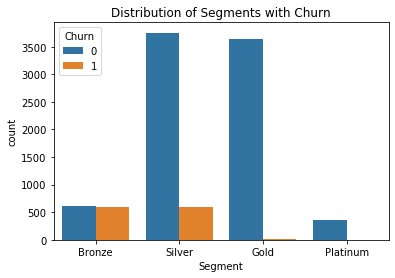

In [128]:
# show distribution of Segments with Churn
sns.countplot(data=rfm_data, x='Segment', hue='Churn')
plt.title('Distribution of Segments with Churn')
plt.show()


In [138]:
# do xgboot model
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

# Drop the 'Account ID', 'Frequency', 'Monetary', 'Recency', 'Churn' columns
X = rfm_data.drop(['Account ID', 'Frequency', 'Monetary', 'Recency', 'RecencyScore', 'Churn', 'Segment', 'RFM'], axis=1)
# transfer to int
# X['RFM'] = X['RFM'].astype(int)
# X['RecencyScore'] = X['RecencyScore'].astype(int)
X['FrequencyScore'] = X['FrequencyScore'].astype(int)
X['MonetaryScore'] = X['MonetaryScore'].astype(int)

# Assign the 'Churn' column to y
y = rfm_data['Churn']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the XGBClassifier
model = XGBClassifier()

# Fit the model on the training data
model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = model.predict(X_test)


In [139]:
# Calculate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Model accuracy: {accuracy:.2f}")

# show feature importance
# Get the feature importance values
importance = model.feature_importances_

# Create a DataFrame to store the feature importance values
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importance
})

# Sort the DataFrame in descending order of the feature importance values
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Display the feature importance values
print(importance_df)


Model accuracy: 0.88
          Feature  Importance
0  FrequencyScore    0.576223
1   MonetaryScore    0.423777
